In [1]:
import pandas as pd
import numpy as np
import sys
sys.path.append('..')
from src.utils import get_config, get_data
from src.ext.HurstIndexSolver import HurstIndexSolver

config = get_config()

In [2]:
ftse100 = get_data('ftse100')
ftsemib = get_data('ftsemib')
sp500 = get_data('s&p500')
ssec = get_data('ssec')

In [49]:
HIS = HurstIndexSolver()

test = ftse100.pct_change().dropna().to_numpy()[:1000]

HIS.EstHurstAggregateVariance(test, minimal=10, method="L2")

np.float64(0.5421497152092963)

## SandBox

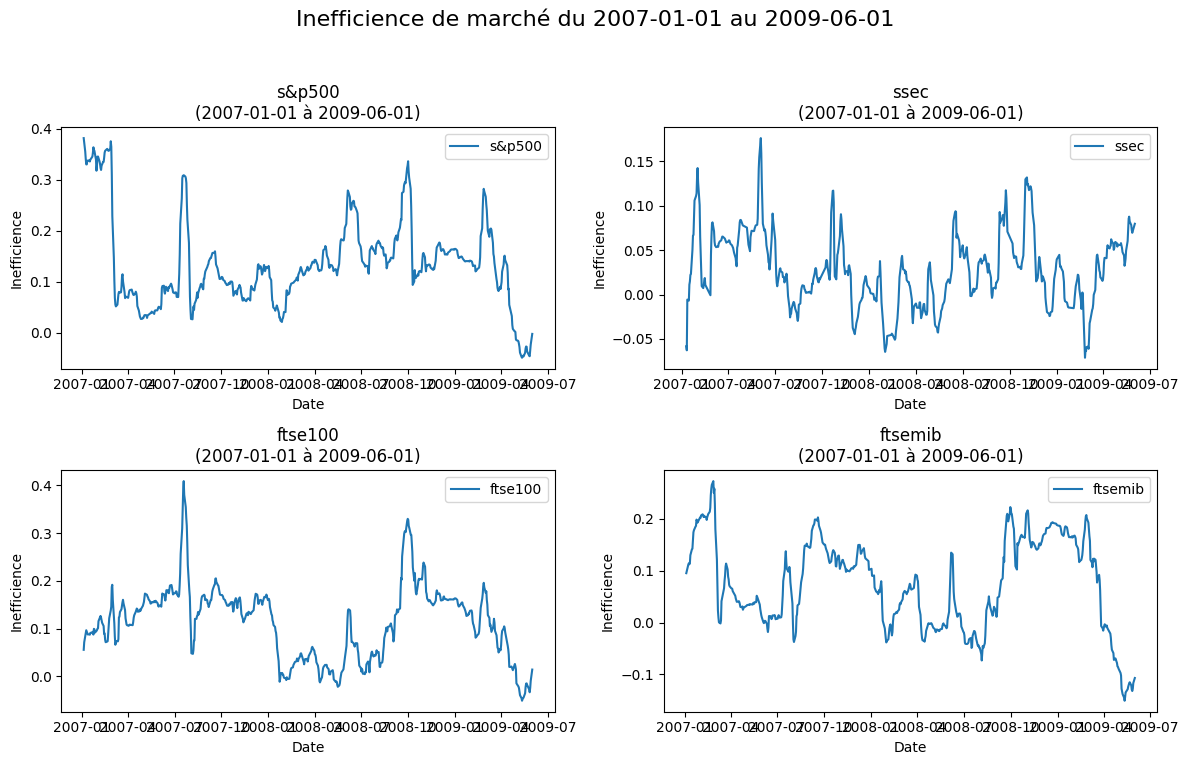

In [59]:
import numpy as np
import math
import pandas as pd
from matplotlib import pyplot as plt

def get_hurst_exponent(self, time_series):
    """Returns the Hurst Exponent of the time series"""
    lags = range(2, self.k)
    # variances of the lagged differences
    tau = [np.std(np.subtract(time_series[lag:], time_series[:-lag])) for lag in lags]
    # calculate the slope of the log plot -> the Hurst Exponent
    reg = np.polyfit(np.log(lags), np.log(tau), 1)
    return reg[0]

# class HurstCalculator:
#     def __init__(self, k=10, window=250):
#         self.k = k
#         self.window = window
    
#     def get_hurst_exponent(self, time_series):
#         """Returns the Hurst Exponent of the time series"""
#         lags = range(2, self.k)
#         # variances of the lagged differences
#         tau = [np.std(np.subtract(time_series[lag:], time_series[:-lag])) for lag in lags]
#         # calculate the slope of the log plot -> the Hurst Exponent
#         reg = np.polyfit(np.log(lags), np.log(tau), 1)
#         return reg[0]
    
#     def rolling_hurst(self, prices: pd.Series) -> pd.Series:
#         """
#         Calcule l'exposant de Hurst en appliquant une fenêtre glissante sur les rendements logarithmiques.
        
#         Paramètres:
#             prices: pd.Series, série de prix indexée par date.
        
#         Retourne:
#             pd.Series des exposants de Hurst, indexée par la date correspondant à la fin de chaque fenêtre.
#         """
#         # Calcul des rendements logarithmiques et élimination de la première valeur NaN
#         log_prices = np.log(prices)
#         hurst_values = []
#         index_list = []
        
#         # Parcourir les fenêtres glissantes
#         for i in range(len(log_prices) - self.window + 1):
#             window_data = log_prices.iloc[i:i+self.window].values
#             h = self.get_hurst_exponent(window_data)
#             hurst_values.append(h)
#             # L'index associé correspond à la date du dernier élément de la fenêtre
#             index_list.append(log_prices.index[i+self.window - 1])
        
#         return pd.Series(hurst_values, index=index_list)
    
#     def calculate_inefficiency(self, prices: pd.Series) -> pd.Series:
#         """
#         Calcule l'inefficience de marché en soustrayant l'exposant de Hurst à 0.5.
        
#         Paramètres:
#             prices: pd.Series, série de prix indexée par date.
        
#         Retourne:
#             pd.Series des inefficiences, indexée par la date correspondant à la fin de chaque fenêtre.
#         """
#         hurst_series = self.rolling_hurst(prices)
#         inefficiency_series = 0.5 - hurst_series
#         return inefficiency_series

import numpy as np
import pandas as pd
import statsmodels.api as sm
from scipy.linalg import solve
from typing import Tuple

class HurstCalculator:
    def __init__(self, k: int = 10, window: int = 250, method: str = 'classic'):
        """
        Initialize the Hurst Calculator
        
        Parameters:
            k: Number of lags to use
            window: Size of rolling window
            method: 'classic' or 'penalized' regression approach
        """
        self.k = k
        self.window = window
        self.method = method
        self.HIS = HurstIndexSolver()

    def get_rs_hurst(self, log_returns):
        """
        Calculates the Hurst Exponent using the Rescaled Range (R/S) analysis method.
        """
        # Compute log returns
        #log_returns = np.diff(np.log(price_series))
        
        # Create an array of lag values
        lags = range(2, self.k)
        
        # Calculate the array of the variances of the lagged differences
        tau = [np.sqrt(np.std(np.subtract(log_returns[lag:], log_returns[:-lag]))) for lag in lags]
        
        # Use a linear fit to estimate the Hurst Exponent
        poly = np.polyfit(np.log(lags), np.log(tau), 1)
        
        # The Hurst exponent is the slope of the linear fit
        hurst_exponent = poly[0]*2.0
        
        # The fractal dimension is related to the Hurst exponent
        fractal_dimension = 2 - hurst_exponent
        
        return hurst_exponent, fractal_dimension 

    def get_matlab_hurst(self, Signal):
        """
        Calculate the Hurst exponent using the Aggregated Variance Method.
        
        Parameters
        ----------
        Signal : array-like
            1D time series.
            
        Returns
        -------
        hur : float
            Estimated Hurst exponent.
            - hur <= 0.5: the time series is noise.
            - hur > 0.5: the time series exhibits long-term memory (a trend is present).
        """
        # Ensure the signal is a 1D numpy array
        Signal = np.asarray(Signal).flatten()
        N = len(Signal)
        
        var_list = []
        m_list = []
        
        m = 2
        while m <= N/2:
            # Only use m that divides N exactly
            if N % m != 0:
                m += 1
                continue
            k = N // m  # number of segments
            
            means = np.zeros(k)
            for i in range(k):
                segment = Signal[i*m:(i+1)*m]
                means[i] = np.mean(segment)
            
            # Using sample variance (ddof=1) to mimic MATLAB's var behavior
            var_list.append(np.var(means, ddof=1))
            m_list.append(m)
            m += 1

        M = np.array(m_list)
        Var = np.array(var_list)
        
        # Construct the design matrix for linear regression:
        # log(Var) = hX[0] * log(M) + hX[1]
        A = np.column_stack((np.log(M), np.ones(len(M))))
        logVar = np.log(Var)
        
        # Solve the least-squares problem
        hX, _, _, _ = np.linalg.lstsq(A, logVar, rcond=None)
        
        # Compute the Hurst exponent:
        # hur = hX[0]/2 + 1
        hur = hX[0] / 2 + 1
        return hur
        
    def get_penalized_hurst(self, time_series: np.ndarray) -> float:
        """
        Calculate Hurst exponent using penalized regression approach
        
        Parameters:
            time_series: Input time series
            
        Returns:
            Estimated Hurst exponent
        """
        lags = range(2, self.k)
        # Calculate variances of lagged differences
        tau = [np.std(np.subtract(time_series[lag:], time_series[:-lag])) for lag in lags]
        
        # Prepare design matrix X
        log_lags = np.log(lags)
        X = sm.add_constant(log_lags)
        y = np.log(tau)
        
        # Define penalty matrix S (second-order difference penalty) @13
        n = X.shape[1]
        S = np.zeros((n, n))
        S[1,1] = 1  # Penalty only on slope parameter
        
        # Estimate optimal smoothing parameter using GCV @14
        def gcv(lambda_: float) -> float:
            # Penalized least squares estimation
            beta_hat = solve(X.T @ X + lambda_ * S, X.T @ y)
            fitted = X @ beta_hat
            n = len(y)
            A = X @ solve(X.T @ X + lambda_ * S, X.T)
            df = np.trace(A)
            residuals = y - fitted
            gcv = n * np.sum(residuals**2) / (n - df)**2
            return gcv
        
        # Find optimal lambda using grid search
        lambdas = np.logspace(-3, 3, 100)
        gcv_scores = [gcv(lambda_) for lambda_ in lambdas]
        optimal_lambda = lambdas[np.argmin(gcv_scores)]
        
        # Final estimation with optimal lambda @13
        beta_hat = solve(X.T @ X + optimal_lambda * S, X.T @ y)
        return beta_hat[1]  # Return slope coefficient
    
    def get_classic_hurst(self, time_series: np.ndarray) -> float:
        """
        Calculate Hurst exponent using classic regression approach
        
        Parameters:
            time_series: Input time series
            
        Returns:
            Estimated Hurst exponent
        """
        lags = range(2, self.k)
        tau = [np.std(np.subtract(time_series[lag:], time_series[:-lag])) for lag in lags]
        return np.polyfit(np.log(lags), np.log(tau), 1)[0]

    def rolling_hurst(self, prices: pd.Series) -> pd.Series:
        """
        Calculate rolling Hurst exponent using specified method
        
        Parameters:
            prices: Price series indexed by date
            
        Returns:
            Series of Hurst exponents
        """
        log_prices = prices#np.log(prices)
        diff_prices = np.diff(log_prices)
        hurst_values = []
        index_list = []
        
        for i in range(len(log_prices) - self.window + 1):
            window_data = log_prices.iloc[i:i+self.window].values
            window_returns = diff_prices[i:i+self.window]

            
            if self.method == 'penalized':
                h = self.get_penalized_hurst(window_data)
            elif self.method == 'matlab':
                h = self.get_matlab_hurst(window_data)
            elif self.method == 'rs':
                h = self.get_rs_hurst(window_returns)[0]
            elif self.method == 'HIS':
                h = self.HIS.EstHurstAggregateVariance(window_data, minimal=self.k, method="L2")
            else:
                h = self.get_classic_hurst(window_data)

                
            hurst_values.append(h)
            index_list.append(log_prices.index[i+self.window - 1])
            
        return pd.Series(hurst_values, index=index_list)

    def calculate_inefficiency(self, prices: pd.Series) -> Tuple[pd.Series, pd.Series]:
        """
        Calculate market inefficiency and volatility measures
        
        Parameters:
            prices: Price series indexed by date
            
        Returns:
            Tuple of (inefficiency series, conditional volatility series)
        """
        # Calculate Hurst-based inefficiency @13, @14
        hurst_series = self.rolling_hurst(prices)
        inefficiency_series = 0.5 - hurst_series
        
        # Calculate conditional volatility using H-GARCH approach @7
        log_returns = np.log(prices/prices.shift(1)).dropna()
        garch_model = sm.regression.linear_model.OLS(
            inefficiency_series,
            sm.add_constant(log_returns[inefficiency_series.index])
        ).fit()
        
        return inefficiency_series, pd.Series(garch_model.resid**2, index=inefficiency_series.index)
    
class InefficiencyVisualizer:
    def __init__(self, hurst_calculator, datas: dict, dates: dict):
        """
        Paramètres:
            hurst_calculator: instance de HurstCalculator
            datas: dict, clé = nom de la série, valeur = pd.Series de prix indexée par date
            dates: dict, clé = date de début (string ou datetime), valeur = date de fin (string ou datetime)
        """
        self.hurst_calculator = hurst_calculator
        self.datas = datas
        self.dates = dates
        
    def plot_inefficiencies(self):
        """
        Pour chaque période définie dans self.dates, filtre chaque série de prix,
        calcule l'inefficience via HurstCalculator et affiche les résultats dans un subplot
        disposé sur deux colonnes.
        """
        # Pour chaque période à explorer
        for start_date, end_date in self.dates.items():
            # Filtrer chaque série sur la période et compter le nombre de séries
            filtered_datas = {}
            for label, series in self.datas.items():
                # Calculate the adjusted start date by subtracting window size in business days
                adjusted_start = pd.to_datetime(start_date) - pd.tseries.offsets.BDay(self.hurst_calculator.window)
                filtered_series = series.loc[adjusted_start:end_date]
                # Vérifier que la série n'est pas vide
                if not filtered_series.empty:
                    filtered_datas[label] = filtered_series
            n_series = len(filtered_datas)
            if n_series == 0:
                print(f"Aucune donnée pour la période {start_date} à {end_date}.")
                continue

            # Calcul du nombre de lignes pour 2 colonnes
            n_cols = 2
            n_rows = math.ceil(n_series / n_cols)
            
            # Création de la figure et des axes
            fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*6, n_rows*4), squeeze=False)
            axes = axes.flatten()
            
            # Pour chaque série filtrée, calcul et tracé de l'inefficience
            for idx, (label, series) in enumerate(filtered_datas.items()):
                ineff_series, _ = self.hurst_calculator.calculate_inefficiency(series)
                ax = axes[idx]
                ax.plot(ineff_series.index, ineff_series.values, label=label)
                ax.set_title(f"{label}\n({start_date} à {end_date})")
                ax.set_xlabel("Date")
                ax.set_ylabel("Inefficience")
                ax.legend()
            
            # Supprimer les axes vides si nécessaire
            for j in range(idx + 1, len(axes)):
                fig.delaxes(axes[j])
            
            fig.suptitle(f"Inefficience de marché du {start_date} au {end_date}", fontsize=16)
            plt.tight_layout(rect=[0, 0.03, 1, 0.95])
            plt.show()

# Dictionnaire des périodes à explorer
dates = {
    '2007-01-01': '2009-06-01'
}

# Dictionnaire des séries (assurez-vous que ftse100, ftsemib, sp500, ssec sont des pd.Series)
datas = {
    's&p500': sp500,
    'ssec': ssec,
    'ftse100': ftse100,
    'ftsemib': ftsemib
}

# Création de l'instance de HurstCalculator avec vos paramètres
hurst_calc = HurstCalculator(k=10, window=100)

# Calcul des inefficiences et de la volatilité pour chaque série


# Création de l'instance de visualisation et affichage
visualizer = InefficiencyVisualizer(hurst_calculator=hurst_calc, datas=datas, dates=dates)
visualizer.plot_inefficiencies()